# Basics methods for training and prediction using Keras

In [1]:
from IPython.display import display, Markdown
with open('../../doc/env_variables_setup.md', 'r') as fh:
    content = fh.read()
display(Markdown(content))

Environment variables that need to be defined:   
`export DIR_PROJ=your_path_git_repository`  
`export PYTHONPATH=$DIR_PROJ/src`  
`export PATH_TENSORBOARD=your_path_tensorboard`  
`export PATH_DATASETS=your_path_datasets`  
`export PROJECT_ID=your_gcp_project_id`  
`export BUCKET_NAME=your_gcp_gs_bucket_name`  
`export REGION=your_region`  
`export MODEL_DIR_ESTIMATOR_PATH=your_path_to_save_model` 

- Use local Jupyter Lab 
    - you need to have the `jupyter-notebook` Anaconda python environment created [link](local_jupyter_lab_installation.md) 
    - you need to have the `jupyter-notebook` Anaconda python environment activated [link](local_jupyter_lab_installation.md) 
    - then define the environment variables above (copy and paste) 
    - you need to have the `env_multilingual_class` Anaconda python environment created [link](local_jupyter_lab_installation.md)  
    - start Jupyter Lab:  `jupyter lab` 
    - open a Jupyter Lab notebook from `notebook/` 
     - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - choose the proper Anaconda python environment:  `Python [conda env:env_multilingual_class]` [link](conda_env.md) 
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`


- Use GCP Jupyter Lab 
    - Go on GCP
    - open a Cloud Shell
    - `ssh-keygen -t rsa -b 4096 -C firstName_lastName`
    - `cp .ssh/id_rsa.pub .`
    - use Cloud Editor to edit this file `id_rsa.pub` and copy the full content
    - Go on Compute Engine -> Metadata
    - Click SSH Keys
    - Click Edit
    - Click + Add item, copy the content of `id_rsa.pub`
    - You should see firstName_lastName of the left
    - Click Save
    - you need to start a AI Platform instance 
    - open a Jupyter Lab terminal and got to `/home/gcp_user_name/`
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - then `cd proj_multilingual_text_classification/`
    - create the Anacond Python environment `conda env create -f env/environment.yml`
    - create a file `config.sh` in `/home` with the following information: 
    ```
    #!/bin/bash
    
    echo "applying some configuration ..."
    git config --global user.email user_email
    git config --global user.name user_name
    git config --global credential.helper store
        
    # Add here the enviroment variables from above below
    export DIR_PROJ= ...
    ...
  
    cd /home/gcp_user_name/
    
    conda activate env_multilingual_class

    export PS1="[\e[91m\]\u@:\[\e[32m\]\w/]$"
    ```
    - Got to AI Platform Notebook, select your instance and click "Reset".
    - Wait and reshreh you Web browser with the Notebook


## Import packages

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from absl import logging
import matplotlib.pyplot as plt
import os

## Define paths

In [3]:
try:
    data_dir=os.environ['PATH_DATASETS']
except:
    print('missing PATH_DATASETS')

# Import local packages

In [4]:
import utils.model_metrics  as model_metrics

In [5]:
import importlib
importlib.reload(model_metrics);

## Getting and preprocessing data

In [6]:
# Setup logging verbosity
logging.set_verbosity(logging.INFO)

# Define the model's hyperparameters
STEPS_PER_EPOCH = 5
BUFFER_SIZE = 10 # Use a much larger value for real code. 
BATCH_SIZE = 64
NUM_EPOCHS = 5

In [7]:
def input_fn():
    datasets, ds_info = tfds.load(name='mnist', with_info=True, as_supervised=True, data_dir=data_dir)
    mnist_train, mnist_test = datasets['train'], datasets['test']

    BUFFER_SIZE = 10000
    BATCH_SIZE = 64

    def scale(image, label):
        image = tf.cast(image, tf.float32)
        image /= 255
    
        return image, label[..., tf.newaxis]

    train_data = mnist_train.repeat().map(scale).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    test_data = mnist_test.repeat().map(scale).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    return train_data, test_data

In [8]:
train_data, test_data=input_fn()

INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Field info.location from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/Users/tarrade/tensorflow_datasets/mnist/3.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /Users/tarrade/tensorflow_datasets/mnist/3.0.0


## Build the model

In [9]:
def make_model():
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu',
                               kernel_regularizer=tf.keras.regularizers.l2(0.02),
                               input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

In [10]:
model = make_model()

In [11]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                346176    
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                6

## Training the model

In [13]:
print("train")
history=model.fit(train_data,
                  steps_per_epoch=STEPS_PER_EPOCH,
                  epochs=NUM_EPOCHS,
                  verbose = 1)

train
Train for 5 steps
Epoch 1/5
5/5 [==============================] - 2s 374ms/step - loss: 1.6205 - accuracy: 0.4594
Epoch 2/5
5/5 [==============================] - 0s 28ms/step - loss: 1.0158 - accuracy: 0.6812
Epoch 3/5
5/5 [==============================] - 0s 26ms/step - loss: 0.5971 - accuracy: 0.8250
Epoch 4/5
5/5 [==============================] - 0s 22ms/step - loss: 0.4816 - accuracy: 0.8813
Epoch 5/5
5/5 [==============================] - 0s 19ms/step - loss: 0.4934 - accuracy: 0.8625


In [14]:
history.history

{'loss': [1.6205000758171082,
  1.0158034563064575,
  0.5971311807632447,
  0.4816153049468994,
  0.4934419274330139],
 'accuracy': [0.459375, 0.68125, 0.825, 0.88125, 0.8625]}

## Visualization

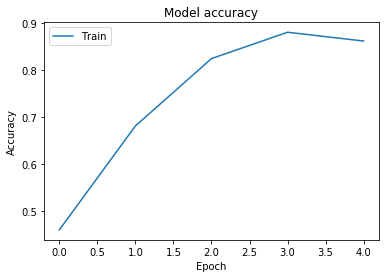

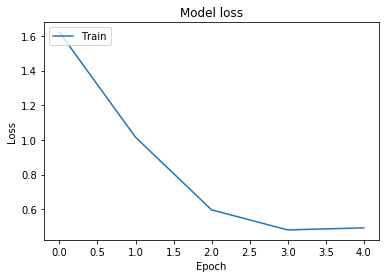

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Evaluating the model

In [16]:
print("evaluate on training dataset")
model.evaluate(train_data,
              steps=1)

evaluate on training dataset
1/1 [==============================] - 1s 1s/step - loss: 1.6816 - accuracy: 0.5625


[1.681606650352478, 0.5625]

In [17]:
print("evaluate on training dataset")
model.evaluate(test_data,
               steps=1)

evaluate on training dataset
1/1 [==============================] - 1s 970ms/step - loss: 1.7119 - accuracy: 0.4844


[1.7119024991989136, 0.484375]

## Doing prediction withn our model

In [18]:
print("predict on one batch of data")
print(model.predict_on_batch(train_data))

predict on one batch of data
tf.Tensor(
[[0.09492768 0.14044066 0.12408723 0.09606541 0.07863768 0.06083756
  0.05884371 0.08323755 0.1781775  0.08474501]
 [0.09062251 0.06742581 0.09926396 0.10334702 0.06941377 0.08947042
  0.0606926  0.05298369 0.29129177 0.07548846]
 [0.08665083 0.05667479 0.12242063 0.12520784 0.05228753 0.0751212
  0.03782178 0.05361693 0.30006042 0.09013803]
 [0.07980526 0.07282295 0.0808432  0.07446174 0.07869393 0.07364646
  0.04035223 0.08054789 0.30908585 0.10974053]
 [0.09630857 0.1645421  0.08908143 0.10214431 0.07137413 0.08635199
  0.07004599 0.0689699  0.17404543 0.0771362 ]
 [0.08213782 0.06473257 0.06293505 0.07252088 0.09672736 0.08775516
  0.04413221 0.09673356 0.17121197 0.22111347]
 [0.08919524 0.14598851 0.09239491 0.09951443 0.07250362 0.09314346
  0.06720672 0.0671194  0.19569054 0.07724318]
 [0.1022878  0.15083398 0.1149684  0.10106634 0.06668212 0.06404972
  0.05000217 0.07826017 0.2046058  0.06724347]
 [0.09903011 0.06241948 0.05448466 0.0693

In [19]:
print("test on one batch of data")
print(model.test_on_batch(train_data))

test on one batch of data
[1.6816344, 0.53125]
